In [1]:
import numpy              # useful numerical routines
import scipy.special      # special functions library
import scipy.misc         # image processing code
#import imageio           # deprecated as typical
import imageio.v2 as imageio
import matplotlib.pyplot  # import plotting routines


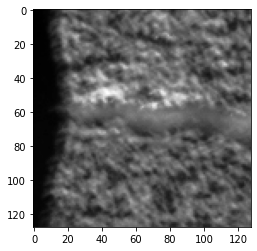

In [2]:
# first read and render to get imgae sizing 
img_array = imageio.imread("/home/sensei/ce-5319-webroot/1-Databases/MaterialCracking/UT-881/Image0.png", as_gray = True)
img_data = 255.0 - img_array.reshape(16384)
#img_data = ((img_data/255.0)*0.99) + 0.01
matplotlib.pyplot.imshow(numpy.asfarray(img_data).reshape((128,128)),cmap = 'Greys') # construct a graphic object #
matplotlib.pyplot.show() # show the graphic object to a window #
matplotlib.pyplot.close('all')

In [3]:
# now we have to flatten each image, put into a csv file, and add the truth table
# myann expects
# truth, image ....
#howmanyimages = 881
import csv
howmanyimages = 20 # a small subset for demonstration
testimage = numpy.array([i for i in range(howmanyimages)])
split = 0.2 # fraction to hold out for testing
numwritten = 0
# training file
outputfile1 = "ut-881-train.csv" #local to this directory
outfile1 = open(outputfile1,'w')  # open the file in the write mode
writer1 = csv.writer(outfile1) # create the csv writer
# testing file
outputfile2 = "ut-881-test.csv" #local to this directory
outfile2 = open(outputfile2,'w')  # open the file in the write mode
writer2 = csv.writer(outfile2) # create the csv writer
# process truth table (absolute pathname)
groundtruth = open("/home/sensei/ce-5319-webroot/1-Databases/MaterialCracking/UT-881/UT-881-GroundTruth.csv","r") #open the file in the reader mode
reader = csv.reader(groundtruth)
truthtable=[] # empty list to store class
for row in reader:
        truthtable.append(row[1])

for irow in range(len(truthtable)-1):
    truthtable[irow]=truthtable[irow+1] # shift all entries by 1
    
#print(truthtable[0:4])

for i in range(howmanyimages):
    # read the image
    image_name="/home/sensei/ce-5319-webroot/1-Databases/MaterialCracking/UT-881/Image"+str(i)+".png" # build image name
    img_array = imageio.imread(image_name, as_gray = True) #read the image
    img_data = 255.0 - img_array.reshape(16384) # flatten the image
    #img_data = ((img_data/255.0)*0.99) + 0.01 # float the pixels
    newimage = numpy.insert(img_data,0,truthtable[i])
    if numpy.random.uniform() <= split:
        #sedn to test
        writer2.writerow(newimage)# write a row to the csv file
        numwritten=numwritten+1
    else:
        #send to train
        writer1.writerow(newimage)# write a row to the csv file
        numwritten=numwritten+1
outfile1.close()
outfile2.close()
print("Images segregated and processed",numwritten)
#print(img_data)
#print(newimage)


Images segregated and processed 20


In [4]:
class neuralNetwork:  # Class Definitions 

    # initialize the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in input, hidden, and output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # learning rate
        self.lr = learningrate
        
        # initalize weight matrices
        #
        # link weight matrices, wih (input to hidden) and
        #                       who (hidden to output)
        # weights inside the arrays are w_i_j where link is from node i
        # to node j in next layer
        #
        # w11 w21
        # w12 w22 etc.
        
        self.wih = (numpy.random.rand(self.hnodes, self.inodes) - 0.5)
        self.who = (numpy.random.rand(self.onodes, self.hnodes) - 0.5)

        # activation function
        self.activation_function = lambda x:scipy.special.expit(x)
        pass

    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert input list into 2D array
        inputs = numpy.array(inputs_list, ndmin=2).T

        # convert target list into 2D array
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)

        # calculate signals from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)

        # calculate signals from output layer
        final_outputs = self.activation_function(final_inputs)

        # calculate output errors (target - model)
        output_errors = targets - final_outputs

        # calculate hidden layer errors (split by weigths recombined in hidden layer)
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # update the weights for the links from hidden to output layer
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

        # update the weights for the links from input to hidden layer
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))                                       
        
        pass

    # query the neural network
    def query(self, inputs_list):
        # convert input list into 2D array
        inputs = numpy.array(inputs_list, ndmin=2).T

        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)

        # calculate signals from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)

        # calculate signals from output layer
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

        pass
print("neuralNetwork Class Loads OK")

neuralNetwork Class Loads OK


In [5]:
# Test case 1 p130 MYONN
# number of input, hidden, and output nodes
input_nodes  = 16384    # 28X28 Pixel Image 
hidden_nodes = 1638    # Should be smaller than input count (or kind of useless)
output_nodes =  2    # Classifications
learning_rate = 0.1   # set learning rate
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate) # create an instance
print("Instance n Created")

Instance n Created


In [6]:
# load a training file
# replace code here with a URL get
## training_data_file = open("mnist_train_100.csv",'r') #connect the file#
training_data_file = open("ut-881-train.csv",'r') #connect the file#
training_data_list = training_data_file.readlines() #read entire contents of file into object: data_list#
training_data_file.close() #disconnect the file#
# print(len(training_data_list))   ## activate for debugging otherwise leave disabled
# train the neural network
howManyTrainingTimes = 0
howManyEpisodes = 1
for times in range(howManyEpisodes):  # added outer loop for repeat training same data set 
    howManyTrainingRecords = 0
    for record in training_data_list:
    # split the values on the commas
        all_values = record.split(',') # split datalist on commas - all records.  Is thing going to work? #
        inputs = (numpy.asfarray(all_values[1:])/255.0 * 0.99) + 0.01
#        inputs = (numpy.asfarray(all_values[1:])/255.0 * 0.99) + 0.01
    # print(inputs)          ## activate for debugging otherwise leave disabled
    # create target output values -- all 0.01 except for the label of 0.99
        targets = numpy.zeros(output_nodes) + 0.01
    # all_values[0] is the target for this record
    #  print(int(numpy.asfarray(all_values[0])))
        targets[int(numpy.asfarray(all_values[0]))] = 0.99
#        print(targets)
    # targets = numpy.asfarray(all_values[0])
        n.train(inputs, targets)
        howManyTrainingRecords += 1
        pass
    howManyTrainingTimes += 1
    learning_rate *= 0.9
    pass
print ("training records processed   = ",howManyTrainingRecords)
print ("training episodes            = ",howManyTrainingTimes)
# load a production file
test_data_file = open("ut-881-test.csv",'r') #connect the file#
#test_data_file = open("mnist_test.csv",'r') #connect the file#
test_data_list = test_data_file.readlines() #read entire contents of file into object: data_list#
test_data_file.close() #disconnect the file#


training records processed   =  16
training episodes            =  1


In [7]:
# test the neural network
scorecard = [] # empty array for keeping score

# run through the records in test_data_list
howManyTestRecords = 0
for record in test_data_list:
    # split the values on the commas
    all_values = record.split(',') # split datalist on commas - all records #
#    correct_label = int(all_values[0]) # correct answer is first element of all_values
    correct_label = int(numpy.asfarray(all_values[0])) # correct answer is first element of all_values
    # scale and shift the inputs
    inputs = (numpy.asfarray(all_values[1:])/255.0 * 0.99) + 0.01
    # query the neural network
    outputs = n.query(inputs)
    predict_label = numpy.argmax(outputs)
    print("predict =",predict_label,correct_label,"= correct") # activate for small test sets only!
    if (predict_label == correct_label):
        scorecard.append(1)
    else:
        scorecard.append(0)
        pass
    howManyTestRecords += 1
    pass
print ("production records processed =", howManyTestRecords)
## print scorecard   # activate for small test sets only!
# calculate performance score, fraction of correct answers
scorecard_array = numpy.asfarray(scorecard)
print ("performance = ",scorecard_array.sum()/scorecard_array.size)

predict = 1 1 = correct
predict = 1 0 = correct


predict = 1 1 = correct


predict = 1 1 = correct
production records processed = 4
performance =  0.75


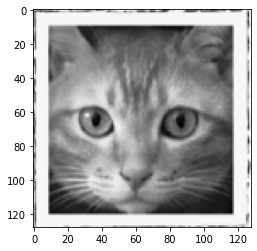

Cat Image  Cracks Detected


In [8]:
# lets try one of my own pictures
# first read and render
#img_array = scipy.misc.imread("cat128.png", flatten = True) Fuckers deprecated this utility!
img_array = imageio.imread("/home/sensei/ce-5319-webroot/1-Databases/MaterialCracking/cat128.png", as_gray = True)
img_data = 255.0 - img_array.reshape(16384)
img_data = ((img_data/255.0)*0.99) + 0.01
matplotlib.pyplot.imshow(numpy.asfarray(img_data).reshape((128,128)),cmap = 'Greys') # construct a graphic object #
matplotlib.pyplot.show() # show the graphic object to a window #
matplotlib.pyplot.close('all')

mynumber = n.query(img_data)
mylabel = numpy.argmax(mynumber)

m0=img_data.mean()  # gather some statistics
v0=img_data.var()

if mylabel == 0:
    msg = "No Cracks Detected"
elif mylabel == 1:
    msg = "Cracks Detected"
print ("Cat Image ", msg)

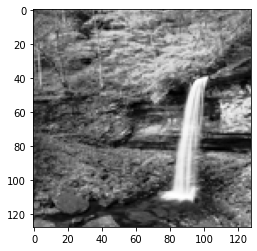

Waterfall Image  Cracks Detected


In [9]:
# lets try one of my own pictures
# first read and render
#img_array = scipy.misc.imread("cat128.png", flatten = True) Fuckers deprecated this utility!
img_array = imageio.imread("/home/sensei/ce-5319-webroot/1-Databases/MaterialCracking/waterfall128.png", as_gray = True)
img_data = 255.0 - img_array.reshape(16384)
img_data = ((img_data/255.0)*0.99) + 0.01
matplotlib.pyplot.imshow(numpy.asfarray(img_data).reshape((128,128)),cmap = 'Greys') # construct a graphic object #
matplotlib.pyplot.show() # show the graphic object to a window #
matplotlib.pyplot.close('all')

mynumber = n.query(img_data)
mylabel = numpy.argmax(mynumber)

m0=img_data.mean()  # gather some statistics
v0=img_data.var()

if mylabel == 0:
    msg = "No Cracks Detected"
elif mylabel == 1:
    msg = "Cracks Detected"
print ("Waterfall Image ", msg)

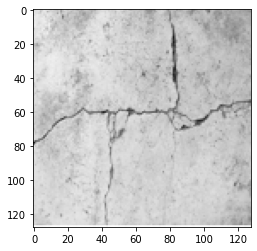

Cracked Concrete  Cracks Detected


In [10]:
# lets try one of my own pictures
# first read and render
#img_array = scipy.misc.imread("cat128.png", flatten = True) Fuckers deprecated this utility!
img_array = imageio.imread("/home/sensei/ce-5319-webroot/1-Databases/MaterialCracking/concrete-cracks.png", as_gray = True)
img_data = 255.0 - img_array.reshape(16384)
img_data = ((img_data/255.0)*0.99) + 0.01
matplotlib.pyplot.imshow(numpy.asfarray(img_data).reshape((128,128)),cmap = 'Greys') # construct a graphic object #
matplotlib.pyplot.show() # show the graphic object to a window #
matplotlib.pyplot.close('all')

mynumber = n.query(img_data)
mylabel = numpy.argmax(mynumber)

m0=img_data.mean()  # gather some statistics
v0=img_data.var()

if mylabel == 0:
    msg = "No Cracks Detected"
elif mylabel == 1:
    msg = "Cracks Detected"
print ("Cracked Concrete ", msg)
